# MultiLayer Perceptron with Pytorch

Implementation of a fully connected network for the image classification task on the Fashion-MNIST set

In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
from itertools import islice as take
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage import io
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm import tqdm
DATA_DIR = '../data'
MEAN = (0.1307)
STD = (0.3081)
BATCH_SIZE = 128
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Data

In [2]:
def display_grid(xs, titles, rows, cols):
    fig, ax = plt.subplots(rows, cols)
    for r in range(rows):
        for c in range(cols):
            i = r * rows + c
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
    fig.tight_layout()
    plt.show()

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!
images[0] shape=(28, 28) dtype=uint8



/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


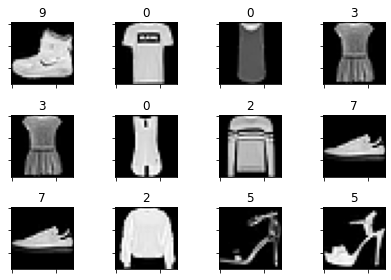

In [3]:
ds = FashionMNIST(
    root=DATA_DIR, 
    train=True, 
    transform=np.array, 
    download=True)
images, labels = [], []
for i in range(12):
    x, y = ds[i]
    images.append(x)
    labels.append(y)
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, 3, 4)

### Training Data

In [4]:
trn_tsfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

trn_ds = FashionMNIST(
    root=DATA_DIR,
    train=True,
    transform=trn_tsfm
)

trn_dl = DataLoader(
    trn_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)

for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


### Testing Data

In [5]:
tst_tsfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

tst_ds = FashionMNIST(
    root=DATA_DIR, 
    train=False,
    transform=tst_tsfm
)

tst_dl = DataLoader(
    tst_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)

for x, y in take(tst_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


### Model

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2 = 128, 10
        self.cls = nn.Sequential(
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            nn.Linear(FC1, FC2)
        )
    
    def forward(self, x):
        x = x.view(-1, self.I)
        x = self.cls(x)
        return x
model = MLP()
print(model)

MLP(
  (cls): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Training 

In [19]:
opt = optim.SGD(model.parameters(), lr=0.005)
loss_hist = []
EPOCHS = 20
for epoch in range(EPOCHS):    
    for x, y_true in trn_dl:
        opt.zero_grad()
        y_lgts = model(x)
        loss = F.cross_entropy(y_lgts, y_true)
        loss.backward()
        opt.step()
    with torch.no_grad(): 
        model.eval()
        losses, accs = [], []
        for x, y_true in take(tst_dl, 10):
            y_lgts = model(x)
            y_prob = F.softmax(y_lgts, 1)
            y_pred = torch.argmax(y_prob, 1)           
            loss = F.cross_entropy(y_lgts, y_true)
            acc = (y_true == y_pred).type(torch.float32).mean()
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')        
        loss_hist.append(loss)
        model.train()

E 0 loss= 51.81 acc=83.20
E 1 loss= 42.33 acc=86.02
E 2 loss=157.96 acc=84.61
E 3 loss= 77.77 acc=86.17
E 4 loss= 51.21 acc=83.91
E 5 loss= 78.72 acc=85.23
E 6 loss=112.85 acc=84.77
E 7 loss= 48.40 acc=85.08
E 8 loss= 46.75 acc=83.52
E 9 loss= 43.42 acc=86.48
E10 loss= 39.47 acc=86.41
E11 loss= 45.19 acc=85.23
E12 loss= 45.26 acc=86.48
E13 loss=109.28 acc=86.33
E14 loss= 49.07 acc=84.92
E15 loss= 43.56 acc=84.22
E16 loss= 78.79 acc=85.08
E17 loss=191.49 acc=83.28
E18 loss=393.83 acc=85.00
E19 loss= 42.08 acc=86.48


In [33]:
opt = optim.SGD(model.parameters(), lr=0.005)
loss_hist = []
EPOCHS = 5
for epoch in range(EPOCHS):    
    for x, y_true in trn_dl:
        opt.zero_grad()
        y_lgts = model(x)
        loss = F.cross_entropy(y_lgts, y_true)
        loss.backward()
        opt.step()
    with torch.no_grad(): 
        model.eval()
        losses, accs = [], []
        for x, y_true in take(tst_dl, 10):
            y_lgts = model(x)
            y_prob = F.softmax(y_lgts, 1)
            y_pred = torch.argmax(y_prob, 1)           
            loss = F.cross_entropy(y_lgts, y_true)
            acc = (y_true == y_pred).type(torch.float32).mean()
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')        
        loss_hist.append(loss)
        model.train()

E 0 loss= 46.07 acc=86.56
E 1 loss= 44.55 acc=87.42
E 2 loss= 50.43 acc=87.27
E 3 loss= 58.50 acc=85.55
E 4 loss= 45.65 acc=87.03


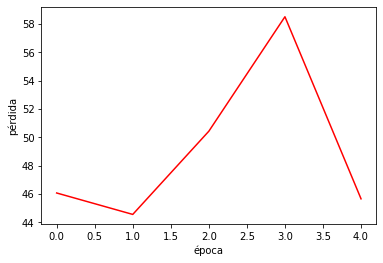

In [34]:
plt.plot(loss_hist, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

In [36]:
model.eval()
with torch.no_grad():         
    accs = []
    for x, y_true in tst_dl:
        y_lgts = model(x)
        y_prob = F.softmax(y_lgts, 1)
        y_pred = torch.argmax(y_prob, 1)
        acc = (y_true == y_pred).type(torch.float32).mean()
        accs.append(acc.item() * 100)
    acc = np.mean(accs)

print(f'Accuracy = {acc:.2f}')

Accuracy = 86.48


### Prediction 

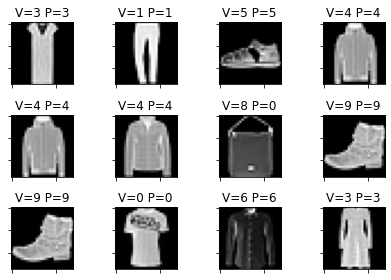

In [37]:
with torch.no_grad(): 
    for x, y_true in take(tst_dl, 1):
        y_lgts = model(x)
        y_prob = F.softmax(y_lgts, 1)
        y_pred = torch.argmax(y_prob, 1)

    x = x[:12].squeeze().numpy()
    y_true = y_true[:12].numpy()
    y_pred = y_pred[:12].numpy()

titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
display_grid(x, titles, 3, 4)